## ⚽ Football ETL – Transfermarkt ➜ Spark ➜ MongoDB + Neo4j
###  João Vitor Averaldo Antunes (813979) · Pedro Enrico Barchi Nogueira (813099) · Rafael Mori Pinheiro (813851)

UFSCar-CC-So-PMD2025-Grupo 10

### Profa. Dra. Sahudy Montenegro González


# Configuração do Ambiente de Execução

Este notebook requer uma configuração de ambiente específica para garantir que o Apache Spark, Delta Lake e os conectores de banco de dados funcionem corretamente. 

---

### 1. Requisitos de Sistema

As seguintes tecnologias devem estar instaladas e configuradas na máquina local:

* **Java Development Kit (JDK):** Versão **17 ou superior**.
    * *Motivo:* O Apache Spark executa na JVM (Java Virtual Machine).
    * *Verificação:* A variável de ambiente `JAVA_HOME` deve estar configurada e apontando para o diretório de instalação do JDK.

* **Apache Spark (Binários):** Versão **4.0.0**.
    * *Motivo:* Esta é a engine de processamento massivo de dados utilizada.
    * *Verificação:* A variável de ambiente `SPARK_HOME` deve estar configurada e apontando para o diretório onde o Spark foi descompactado.

* **Python:** Versão **3.11.x**.
    * *Motivo:* As bibliotecas `pyspark` e `delta-spark` utilizadas neste projeto são compatíveis com esta versão do Python. Versões mais recentes (como 3.13+) podem causar erros de incompatibilidade.
    * *Recomendação (macOS/Linux):* Usar o `pyenv` para gerenciar a versão do Python (`pyenv install 3.11` e `pyenv local 3.11` na pasta do projeto).

---

### 2. Ambiente Virtual e Dependências Python

Para isolar as dependências, este projeto deve ser executado dentro de um ambiente virtual (`venv`).

1.  **Criação:** `python -m venv venv`
2.  **Ativação:** `source venv/bin/activate` (macOS/Linux) ou `.\venv\Scripts\activate` (Windows)

As bibliotecas Python necessárias serão instaladas pela célula de código abaixo. As principais são:
* `pyspark`: A API Python para interagir com o Spark.
* `delta-spark`: A biblioteca para habilitar o suporte ao formato Delta Lake.
* `python-dotenv`: Para gerenciar variáveis de ambiente (credenciais) a partir de um arquivo `.env`.

---

### 3. Arquivos de Conectores (.jar)

Devido a possíveis restrições de rede ou para garantir consistência, este projeto utiliza o método de carregamento manual de JARs. Crie uma pasta chamada `jars` na raiz do projeto e certifique-se de que ela contém os seguintes quatro arquivos:

1.  `delta-spark_2.13-4.0.0.jar`
2.  `delta-storage-4.0.0.jar`
3.  `mongo-spark-connector_2.13-10.5.0.jar`
4.  `mongodb-driver-sync-5.5.1.jar`
5.  `mongodb-driver-core-5.1.2.jar`
6.  `neo4j-connector-apache-spark_2.13-5.3.8_for_spark_3.jar`
7.  `bson-5.1.2.jar`

---

### 4. Arquivo de Variáveis de Ambiente (`.env`)

Crie um arquivo chamado `.env` na raiz do projeto para armazenar as credenciais dos bancos de dados de forma segura. O arquivo deve seguir o seguinte formato:

```plaintext
# Credenciais do MongoDB
MONGO_URI="mongodb+srv://<user>:<password>@<cluster-url>/"

# Credenciais do Neo4j
NEO4J_URI="bolt://localhost:7687"
NEO4J_USERNAME="neo4j"
NEO4J_PASSWORD="your_password"

In [16]:
import os
import sys

# Instala os pacotes necessários
!{sys.executable} -m pip install "pyspark>=4.0.0" "delta-spark>=4.0.0" python-dotenv matplotlib seaborn

print("\n✅ Dependências Python instaladas com sucesso!")
print("Lembre-se de reiniciar o kernel ('Kernel > Restart Kernel...') para que as mudanças tenham efeito.")

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 905.0 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 2.8 MB/s eta 0:00:0000:0100:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.6/254.6 kB 3.2 MB/s eta 0:00:00a 0:00:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 4.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 3.4 MB/s eta 0:00:00a 

### Inicialização da Sessão Spark

A célula a seguir inicializa a `SparkSession`, que é o ponto de entrada para qualquer funcionalidade do Spark. Utilizamos o padrão de projeto **Builder** para configurar a sessão antes de criá-la.

As configurações aplicadas são cruciais:
* `appName`: Define um nome para a nossa aplicação, útil para monitoramento na UI do Spark.
* `spark.jars`: Especifica os caminhos para os arquivos `.jar` que carregamos manualmente. Esta abordagem foi escolhida para contornar possíveis problemas de rede e garantir consistência, fornecendo ao Spark os drivers para **Delta Lake**, **MongoDB** e **Neo4j**.
* `spark.sql.extensions` e `spark.sql.catalog.spark_catalog`: Habilitam as funcionalidades avançadas do Delta Lake, como o suporte a comandos SQL específicos do Delta.
* `spark.mongodb.*`: Pré-configura os parâmetros de conexão padrão para o MongoDB, que serão usados nas operações de escrita.
* `spark.neo4j.*`: Pré-configura os parâmetros de conexão padrão para o Neo4j, que serão usados nas operações de escrita.

In [16]:
# Python Built-in e Typing
import os
from typing import List
from datetime import datetime
import re # Necessário para a UDF parse_euro

# Bibliotecas de terceiros (Data Science e Plotagem)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Bibliotecas do PySpark
from pyspark.sql import SparkSession, DataFrame, Window, Row
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import col, sum as spark_sum, count, isnan, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from delta import configure_spark_with_delta_pip

# Gerenciamento de variáveis de ambiente
from dotenv import load_dotenv

sns.set(style="whitegrid", rc={"figure.figsize":(10, 6)})

# Configure o caminho do Java
java_path = "/Users/rafaelmoripinheiro/.sdkman/candidates/java/current"
os.environ["JAVA_HOME"] = java_path

# -- variáveis de ambiente --
load_dotenv('./.env')

BASE_PATH = "./raw_data"
PATH      = "./pre-processing"        # onde vai gravar os Delta
os.makedirs(PATH, exist_ok=True)

MONGO_URI  = os.getenv("MONGO_URI")
NEO4J_URL  = os.getenv("NEO4J_URI")
NEO4J_AUTH = (os.getenv("NEO4J_USERNAME"), os.getenv("NEO4J_PASSWORD"))

# --- Caminhos para os JARs locais ---
delta_spark_jar     = "jars/delta-spark_2.13-4.0.0.jar"
delta_storage_jar   = "jars/delta-storage-4.0.0.jar"

mongo_connector_jar = "jars/mongo-spark-connector_2.13-10.5.0.jar"
mongo_driver_core   = "jars/mongodb-driver-core-5.1.2.jar"
mongo_driver_sync   = "jars/mongodb-driver-sync-5.1.2.jar"
mongo_bson          = "jars/bson-5.1.2.jar"

# Caminho para o JAR do Neo4j Spark Connector
neo4j_jar = "jars/neo4j-connector-apache-spark_2.13-5.3.8_for_spark_3.jar"

# --- Constrói e CRIA a sessão Spark ---
print("Iniciando a construção da sessão Spark para Delta e MongoDB...")

spark = (
    SparkSession.builder
      .appName("FootballPipeline-MongoFocus")
      .config(
          "spark.jars",
          ",".join([
              delta_spark_jar,
              delta_storage_jar,
              mongo_connector_jar,
              mongo_driver_core,
              mongo_driver_sync,
              mongo_bson,
              neo4j_jar
          ])
      )
      .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
      .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
      .config("spark.mongodb.write.connection.uri", MONGO_URI)   
      .config("spark.mongodb.write.database", "football")
      .config("spark.neo4j.url", NEO4J_URL)  # URL do Neo4j
      .config("spark.neo4j.authentication.basic.username", NEO4J_AUTH[0])  # Username
      .config("spark.neo4j.authentication.basic.password", NEO4J_AUTH[1])  # Password
      .getOrCreate()
)

print(f"✅ Sessão Spark para Delta e MongoDB iniciada com sucesso! Versão: {spark.version}")

Iniciando a construção da sessão Spark para Delta e MongoDB...
✅ Sessão Spark para Delta e MongoDB iniciada com sucesso! Versão: 4.0.0


--- 
### Definição Explícita dos Schemas

Antes de carregar os dados, definimos explicitamente o `schema` (a estrutura e os tipos de dados) para cada um dos nossos arquivos CSV de origem.

Esta é uma **prática recomendada fundamental** em pipelines de dados robustos, em vez de usar a opção `inferSchema=True` do Spark, pelos seguintes motivos:

* **Performance:** Evita que o Spark precise ler os dados uma vez a mais apenas para inferir os tipos de dados, o que pode ser muito custoso em datasets grandes.
* **Integridade e Prevenção de Erros:** Garante que os dados sejam lidos com os tipos corretos desde o início. Isso previne erros de tipagem em operações futuras.
* **Consistência:** O pipeline não quebrará se uma amostra dos dados levar o Spark a inferir um tipo incorreto.

In [2]:
appearances_schema = T.StructType([
    T.StructField("appearance_id",              T.StringType()),
    T.StructField("game_id",                    T.LongType()),
    T.StructField("player_id",                  T.LongType()),
    T.StructField("player_club_id",             T.LongType()),
    T.StructField("player_current_club_id",     T.LongType()),
    T.StructField("date",                       T.DateType()),
    T.StructField("player_name",                T.StringType()),
    T.StructField("competition_id",             T.StringType()),
    T.StructField("yellow_cards",               T.IntegerType()),
    T.StructField("red_cards",                  T.IntegerType()),
    T.StructField("goals",                      T.IntegerType()),
    T.StructField("assists",                    T.IntegerType()),
    T.StructField("minutes_played",             T.IntegerType())
])

In [3]:
club_games_schema = T.StructType([
    T.StructField("game_id",            T.LongType()),
    T.StructField("club_id",            T.LongType()),
    T.StructField("own_goals",          T.IntegerType()),
    T.StructField("own_position",       T.IntegerType()),
    T.StructField("own_manager_name",   T.StringType()),
    T.StructField("opponent_id",        T.LongType()),
    T.StructField("opponent_goals",     T.IntegerType()),
    T.StructField("opponent_position",  T.IntegerType()),
    T.StructField("opponent_manager_name", T.StringType()),
    T.StructField("hosting",            T.StringType()),
    T.StructField("is_win",             T.IntegerType())
])

clubs_schema = T.StructType([
    T.StructField("club_id",                  T.LongType()),
    T.StructField("club_code",                T.StringType()),
    T.StructField("name",                     T.StringType()),
    T.StructField("domestic_competition_id",  T.StringType()),
    T.StructField("total_market_value",       T.StringType()),
    T.StructField("squad_size",               T.IntegerType()),
    T.StructField("average_age",              T.DoubleType()),
    T.StructField("foreigners_number",        T.IntegerType()),
    T.StructField("foreigners_percentage",    T.DoubleType()),
    T.StructField("national_team_players",    T.IntegerType()),
    T.StructField("stadium_name",             T.StringType()),
    T.StructField("stadium_seats",            T.IntegerType()),
    T.StructField("net_transfer_record",      T.StringType()),
    T.StructField("coach_name",               T.StringType()),
    T.StructField("last_season",              T.IntegerType()),
    T.StructField("filename",                 T.StringType()),
    T.StructField("url",                      T.StringType())
])


In [4]:
competitions_schema = T.StructType([
    T.StructField("competition_id",          T.StringType()),
    T.StructField("competition_code",        T.StringType()),
    T.StructField("name",                    T.StringType()),
    T.StructField("sub_type",                T.StringType()),
    T.StructField("type",                    T.StringType()),
    T.StructField("country_id",              T.IntegerType()),
    T.StructField("country_name",            T.StringType()),
    T.StructField("domestic_league_code",    T.StringType()),
    T.StructField("confederation",           T.StringType()),
    T.StructField("url",                     T.StringType()),
    T.StructField("is_major_national_league",T.BooleanType())
])

In [5]:
game_events_schema = T.StructType([
    T.StructField("game_event_id",   T.StringType()),
    T.StructField("date",            T.DateType()),
    T.StructField("game_id",         T.LongType()),
    T.StructField("minute",          T.IntegerType()),
    T.StructField("type",            T.StringType()),
    T.StructField("club_id",         T.LongType()),
    T.StructField("player_id",       T.LongType()),
    T.StructField("description",     T.StringType()),
    T.StructField("player_in_id",    T.LongType()),
    T.StructField("player_assist_id",T.LongType())
])

game_lineups_schema = T.StructType([
    T.StructField("game_lineups_id", T.StringType()),
    T.StructField("date",            T.DateType()),
    T.StructField("game_id",         T.LongType()),
    T.StructField("player_id",       T.LongType()),
    T.StructField("club_id",         T.LongType()),
    T.StructField("player_name",     T.StringType()),
    T.StructField("type",            T.StringType()),
    T.StructField("position",        T.StringType()),
    T.StructField("number",          T.IntegerType()),
    T.StructField("team_captain",    T.IntegerType())
])

games_schema = T.StructType([
    T.StructField("game_id",              T.LongType()),
    T.StructField("competition_id",       T.StringType()),
    T.StructField("season",               T.IntegerType()),
    T.StructField("round",                T.StringType()),
    T.StructField("date",                 T.DateType()),
    T.StructField("home_club_id",         T.LongType()),
    T.StructField("away_club_id",         T.LongType()),
    T.StructField("home_club_goals",      T.IntegerType()),
    T.StructField("away_club_goals",      T.IntegerType()),
    T.StructField("home_club_position",   T.IntegerType()),
    T.StructField("away_club_position",   T.IntegerType()),
    T.StructField("home_club_manager_name", T.StringType()),
    T.StructField("away_club_manager_name", T.StringType()),
    T.StructField("stadium",              T.StringType()),
    T.StructField("attendance",           T.IntegerType()),
    T.StructField("referee",              T.StringType()),
    T.StructField("url",                  T.StringType()),
    T.StructField("home_club_formation",  T.StringType()),
    T.StructField("away_club_formation",  T.StringType()),
    T.StructField("home_club_name",       T.StringType()),
    T.StructField("away_club_name",       T.StringType()),
    T.StructField("aggregate",            T.StringType()),
    T.StructField("competition_type",     T.StringType())
])

In [6]:
valuations_schema = T.StructType([
    T.StructField("player_id",        T.LongType()),
    T.StructField("date",             T.DateType()),
    T.StructField("market_value_in_eur", T.DoubleType()),
    T.StructField("current_club_id",  T.LongType()),
    T.StructField("player_club_domestic_competition_id", T.StringType())
])

In [7]:
players_schema = T.StructType([
    T.StructField("player_id",            T.LongType()),
    T.StructField("first_name",           T.StringType()),
    T.StructField("last_name",            T.StringType()),
    T.StructField("name",                 T.StringType()),
    T.StructField("last_season",          T.IntegerType()),
    T.StructField("current_club_id",      T.LongType()),
    T.StructField("player_code",          T.StringType()),
    T.StructField("country_of_birth",     T.StringType()),
    T.StructField("city_of_birth",        T.StringType()),
    T.StructField("country_of_citizenship",T.StringType()),
    T.StructField("date_of_birth",        T.TimestampType()),
    T.StructField("sub_position",         T.StringType()),
    T.StructField("position",             T.StringType()),
    T.StructField("foot",                 T.StringType()),
    T.StructField("height_in_cm",         T.IntegerType()),
    T.StructField("contract_expiration_date", T.StringType()),
    T.StructField("agent_name",           T.StringType()),
    T.StructField("image_url",            T.StringType()),
    T.StructField("url",                  T.StringType()),
    T.StructField("current_club_domestic_competition_id", T.StringType()),
    T.StructField("current_club_name",    T.StringType()),
    T.StructField("market_value_in_eur",  T.DoubleType()),
    T.StructField("highest_market_value_in_eur", T.DoubleType())
])

transfers_schema = T.StructType([
    T.StructField("player_id",        T.LongType()),
    T.StructField("transfer_date",    T.DateType()),
    T.StructField("transfer_season",  T.StringType()),
    T.StructField("from_club_id",     T.LongType()),
    T.StructField("to_club_id",       T.LongType()),
    T.StructField("from_club_name",   T.StringType()),
    T.StructField("to_club_name",     T.StringType()),
    T.StructField("transfer_fee",     T.DoubleType()),
    T.StructField("market_value_in_eur", T.DoubleType()),
    T.StructField("player_name",      T.StringType())
])

---
### Camada Bronze: Ingestão dos Dados Brutos

Nesta seção, realizamos a ingestão dos dados. Seguindo os princípios da **arquitetura Medalhão**, esta primeira camada, a **Bronze**, representa os dados em seu estado bruto, exatamente como foram recebidos da fonte.

A função `load_csv` é um utilitário simples que utiliza os `schemas` definidos anteriormente para carregar cada arquivo CSV em um DataFrame do Spark. Cada DataFrame com o sufixo `_bronze` corresponde a uma tabela de dados brutos.


In [ ]:
def load_csv(name, schema):
    return (spark.read
            .option("header", True)
            .schema(schema)
            .csv(f"{BASE_PATH}/{name}.csv"))

apps_bronze         = load_csv("appearances",        appearances_schema)
club_games_bronze   = load_csv("club_games",         club_games_schema)
clubs_bronze        = load_csv("clubs",              clubs_schema)
competitions_bronze = load_csv("competitions",       competitions_schema)
events_bronze       = load_csv("game_events",        game_events_schema)
lineups_bronze      = load_csv("game_lineups",       game_lineups_schema)
games_bronze        = load_csv("games",              games_schema)
valuations_bronze   = load_csv("player_valuations",  valuations_schema)
players_bronze      = load_csv("players",            players_schema)
transfers_bronze    = load_csv("transfers",          transfers_schema)

---
### Análise exploratória

Nesta seção, vamos realizar uma análise exploratória profunda nos dados brutos para identificar inconsistências, valores ausentes (lacunas) e outliers. O objetivo é criar um plano de ação para a limpeza e validação que ocorrerá na camada Silver.

Para as visualizações, usaremos matplotlib e seaborn. Como o volume de dados pode ser grande, a estratégia será agregar os dados no Spark e então converter o resultado agregado para um DataFrame Pandas para plotagem.

*A análise seguirá os seguintes passos:*

1. Definição das Funções de Apoio: Centralização de todas as funções helper para análise e visualização.

2. Visão Geral e Validação Estrutural: Uma primeira olhada nas dimensões, schemas e estatísticas descritivas dos dados.

3. Análise de Qualidade e Integridade: Verificação de valores nulos e da integridade referencial entre as tabelas.

4. Amostragem para Visualização: Extração de amostras dos dados para plotagem eficiente.

5. Análise de Distribuições (Análise Univariada): Investigação de variáveis individuais para entender suas características.

6. Análise de Relacionamentos e Tendências (Análise Multivariada): Exploração de correlações e tendências temporais.


#### Helpers

In [32]:
def checkup_basico(df, df_name):
    """Imprime o número de linhas, o schema e uma amostra de um DataFrame."""
    print(f"--- Check-up Básico para: {df_name} ---")
    try:
        num_rows = df.count()
        print(f"Número de Linhas: {num_rows}")
        if num_rows > 0:
            print("Schema:")
            df.printSchema()
            print("Amostra dos Dados:")
            df.show(5, truncate=False)
        else:
            print("DataFrame está vazio.")
    except Exception as e:
        print(f"Ocorreu um erro ao processar {df_name}: {e}")
    print("\n" + "="*80 + "\n")

def analisar_nulos(df: DataFrame, df_name: str):
    """
    Calcula e exibe a contagem e o percentual de valores nulos para cada coluna,
    tratando os tipos de dados de forma segura.
    """
    print(f"--- Análise de Nulos para: {df_name} ---")
    try:
        total_rows = df.count()
        if total_rows == 0:
            print("DataFrame está vazio.")
            return

        tipos_colunas = dict(df.dtypes)
        
        expressoes_contagem = []

        for c in df.columns:
            condicao = F.col(c).isNull()
            
            if tipos_colunas[c] in ['float', 'double']:
                condicao = condicao | F.isnan(c)
            
            expressoes_contagem.append(F.sum(F.when(condicao, 1).otherwise(0)).alias(c))

        null_counts = df.select(expressoes_contagem).first().asDict()
        
        print(f"Resultados para {total_rows} linhas:")
        has_nulls = False
        for column, null_count in sorted(null_counts.items(), key=lambda item: -item[1]):
            if null_count > 0:
                percentage = (null_count / total_rows) * 100
                print(f"Coluna '{column}': {null_count} nulos ({percentage:.2f}%)")
                has_nulls = True
        
        if not has_nulls:
            print("✅ Nenhuma coluna com valores nulos encontrada.")
            
    except Exception as e:
        print(f"Ocorreu um erro ao analisar nulos em {df_name}: {e}")
    print("\n" + "="*80 + "\n")

def checar_integridade(df_principal, pk_principal, df_referencia, fk_referencia, df_name):
    """Verifica a integridade referencial entre dois DataFrames usando um anti join."""
    print(f"--- Verificando Integridade Referencial: {df_name} ---")
    print(f"Verificando se todos os '{fk_referencia}' em df_referencia existem como '{pk_principal}' em df_principal.")
    try:
        # Renomeia a chave estrangeira para o anti join
        df_referencia_renamed = df_referencia.withColumnRenamed(fk_referencia, pk_principal)
        
        # Filtra nulos na chave para não contar como órfãos
        registros_orfaos = df_referencia_renamed.filter(col(pk_principal).isNotNull()).join(
            df_principal.select(pk_principal).distinct(), 
            on=pk_principal, 
            how="anti"
        )
        
        count_orfaos = registros_orfaos.count()
        
        if count_orfaos > 0:
            print(f"⚠️ ENCONTRADOS {count_orfaos} registros órfãos!")
            print(f"Exemplos de chaves órfãs em '{fk_referencia}':")
            registros_orfaos.select(pk_principal).show(5)
        else:
            print("✅ Nenhuma inconsistência de integridade encontrada.")
            
    except Exception as e:
        print(f"Ocorreu um erro ao checar a integridade de {df_name}: {e}")
    print("\n" + "="*80 + "\n")

def identificar_outliers(df: DataFrame, coluna: str, colunas_id: list = None):
    """
    Identifica e mostra outliers em uma coluna numérica usando o método IQR.

    Args:
        df (DataFrame): O DataFrame a ser analisado.
        coluna (str): A coluna numérica para verificar outliers.
        colunas_id (list, optional): Uma lista de colunas de identificação para
                                     exibir junto com o outlier.
    """
    print(f"--- Análise de Outliers para: {coluna} ---")

    # Calcula Q1 e Q3
    try:
        quantiles = df.approxQuantile(coluna, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
    except Exception as e:
        print(f"Não foi possível calcular os quantis para a coluna '{coluna}'. Verifique se ela é numérica. Erro: {e}")
        return

    # Calcula o Intervalo Interquartil (IQR)
    if q1 is None or q3 is None:
        print(f"Não foi possível calcular o IQR para a coluna '{coluna}' (valores nulos).")
        return
    iqr = q3 - q1

    # Define os limites para detecção de outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}")
    print(f"Limite Inferior: {lower_bound}, Limite Superior: {upper_bound}")

    # Filtra os outliers
    outliers_df = df.filter((F.col(coluna) < lower_bound) | (F.col(coluna) > upper_bound))

    outliers_count = outliers_df.count()
    if outliers_count > 0:
        print(f"⚠️ Encontrados {outliers_count} outliers na coluna '{coluna}'. Amostra:")

        # --- LÓGICA DE SELEÇÃO DINÂMICA ---
        # Define as colunas a serem mostradas
        if colunas_id:
            colunas_para_mostrar = colunas_id + [coluna]
        else:
            # Se nenhuma coluna de ID for fornecida, mostra apenas a coluna com outlier
            colunas_para_mostrar = [coluna]

        # Seleciona as colunas dinamicamente
        outliers_df.select(colunas_para_mostrar).orderBy(F.desc(coluna)).show(10, truncate=False)
    else:
        print(f"✅ Nenhum outlier encontrado para '{coluna}'.")
    print("\n" + "="*80 + "\n")

def plotar_histograma(series: pd.Series, titulo: str, xlabel: str, bins: int = 30, cor: str = 'skyblue', yscale: str = 'linear', kde: bool = True):
    """
    Plota um histograma para uma série de dados.

    Args:
        series (pd.Series): A série de dados a ser plotada.
        titulo (str): O título do gráfico.
        xlabel (str): O rótulo do eixo X.
        bins (int): O número de bins do histograma.
        cor (str): A cor do histograma.
        yscale (str): A escala do eixo Y ('linear' ou 'log').
        kde (bool): Se deve ou não exibir a linha de densidade (KDE).
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(series.dropna(), kde=kde, bins=bins, color=cor).set(
        title=titulo,
        xlabel=xlabel
    )
    plt.yscale(yscale)
    plt.show()

def plotar_boxplot(series: pd.Series, titulo: str, xlabel: str, xscale: str = 'linear'):
    """
    Plota um boxplot para uma série de dados.

    Args:
        series (pd.Series): A série de dados a ser plotada.
        titulo (str): O título do gráfico.
        xlabel (str): O rótulo do eixo X.
        xscale (str): A escala do eixo X ('linear' ou 'log').
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=series.dropna()).set(
        title=titulo,
        xlabel=xlabel
    )
    plt.xscale(xscale)
    plt.show()

def plotar_barras_contagem(series: pd.Series, titulo: str, ylabel: str, top_n: int = 10, cor: str = 'skyblue'):
    """
    Plota um gráfico de barras com a contagem das categorias mais frequentes.

    Args:
        series (pd.Series): A série de dados categóricos.
        titulo (str): O título do gráfico.
        ylabel (str): O rótulo do eixo Y.
        top_n (int): O número de categorias a serem exibidas.
        cor (str): A cor das barras.
    """
    plt.figure(figsize=(10, 6))
    series.value_counts().nlargest(top_n).plot(kind='bar', color=cor).set(
        title=titulo,
        ylabel=ylabel
    )
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plotar_histogramas_comparativos(series1: pd.Series, label1: str, cor1: str,
                                    series2: pd.Series, label2: str, cor2: str,
                                    titulo: str):
    """
    Plota dois histogramas sobrepostos para comparação.

    Args:
        series1 (pd.Series): A primeira série de dados.
        label1 (str): O rótulo da primeira série.
        cor1 (str): A cor da primeira série.
        series2 (pd.Series): A segunda série de dados.
        label2 (str): O rótulo da segunda série.
        cor2 (str): A cor da segunda série.
        titulo (str): O título do gráfico.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(series1.dropna(), color=cor1, label=label1, kde=True, stat="density", linewidth=0)
    sns.histplot(series2.dropna(), color=cor2, label=label2, kde=True, stat="density", linewidth=0)
    plt.title(titulo)
    plt.legend()
    plt.show()

def plotar_matriz_correlacao(df, colunas_numericas, df_name):
    """Calcula e plota uma matriz de correlação para as colunas especificadas."""
    print(f"--- Matriz de Correlação para: {df_name} ---")
    
    # Remove linhas onde qualquer uma das colunas de interesse é nula
    df_filtered = df.select(colunas_numericas).dropna()
    
    if df_filtered.count() == 0:
        print("Não há dados suficientes para calcular a correlação após remover nulos.")
        return

    # O Spark espera que as colunas estejam em um único vetor
    assembler = VectorAssembler(inputCols=colunas_numericas, outputCol="features")
    df_vector = assembler.transform(df_filtered).select("features")

    # Calcula a matriz de correlação de Pearson
    matrix = Correlation.corr(df_vector, "features").head()
    
    if matrix:
        corr_matrix = matrix[0].toArray()
        corr_pd = pd.DataFrame(corr_matrix, columns=colunas_numericas, index=colunas_numericas)
        
        # Plotando o heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_pd, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title(f'Matriz de Correlação para {df_name}')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.show()
    else:
        print("Não foi possível calcular a matriz de correlação.")
    print("\n" + "="*80 + "\n")

def plotar_distribuicao_categorica(df, coluna, df_name, top_n=15):
    """Calcula e plota a distribuição de uma coluna categórica."""
    print(f"--- Distribuição Categórica para: {df_name} [{coluna}] ---")
    
    # Agrupa por categoria e conta as ocorrências
    counts_df = df.groupBy(coluna).count().orderBy(F.desc("count")).limit(top_n)
    counts_pd = counts_df.toPandas()
    
    if counts_pd.empty:
        print("Não há dados para plotar.")
        return

    plt.figure(figsize=(12, 7))
    sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')
    plt.title(f'Distribuição de {df_name} por {coluna} (Top {top_n})')
    plt.xlabel('Contagem')
    plt.ylabel(coluna)
    plt.show()
    print("\n" + "="*80 + "\n")

def plotar_serie_temporal(
    df: DataFrame,
    coluna_tempo: str,
    titulo: str,
    xlabel: str,
    ylabel: str,
    agregacao: str = 'count',
    coluna_valor: str = None,
    unidade_tempo: str = None,
    cor: str = 'royalblue',
    marker: str = 'o'
):
    """
    Realiza uma agregação temporal em um DataFrame Spark e plota o resultado como um gráfico de linha.

    Args:
        df (DataFrame): O DataFrame Spark de origem.
        coluna_tempo (str): A coluna a ser usada como eixo do tempo.
        titulo (str): O título do gráfico.
        xlabel (str): O rótulo do eixo X.
        ylabel (str): O rótulo do eixo Y.
        agregacao (str): O tipo de agregação ('count', 'avg', 'sum').
        coluna_valor (str): A coluna numérica a ser agregada (necessária para 'avg' e 'sum').
        unidade_tempo (str): A unidade a ser extraída da coluna de tempo (ex: 'year').
        cor (str): A cor da linha do gráfico.
        marker (str): O marcador dos pontos no gráfico.
    """
    print(f"--- Gerando Série Temporal: {titulo} ---")

    # Define o nome da coluna temporal que será usada no group by
    if unidade_tempo == 'year':
        df_agg = df.withColumn("tempo_agg", F.year(coluna_tempo))
    else:
        # Usa a coluna como está se nenhuma unidade for especificada
        df_agg = df.withColumn("tempo_agg", F.col(coluna_tempo))

    # Realiza a agregação apropriada
    if agregacao == 'count':
        resultado_spark = df_agg.groupBy("tempo_agg").count().withColumnRenamed("count", "valor_agg")
    elif agregacao in ['avg', 'sum']:
        if not coluna_valor:
            raise ValueError(f"O argumento 'coluna_valor' é obrigatório para a agregação '{agregacao}'.")
        if agregacao == 'avg':
            agg_func = F.avg
        else:
            agg_func = F.sum
        resultado_spark = df_agg.groupBy("tempo_agg").agg(agg_func(coluna_valor).alias("valor_agg"))
    else:
        raise ValueError(f"Agregação '{agregacao}' não suportada. Use 'count', 'avg' ou 'sum'.")

    # Ordena pelo tempo e converte para Pandas
    resultado_pd = resultado_spark.orderBy("tempo_agg").toPandas()

    # Plotagem
    plt.figure(figsize=(14, 7))
    sns.lineplot(data=resultado_pd, x='tempo_agg', y='valor_agg', marker=marker, color=cor)
    plt.title(titulo, fontsize=16)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')
    plt.show()
    print("\n" + "="*80 + "\n")

def base_clean(df, pk: List[str]):
    return (df
            .dropDuplicates(pk)
            .withColumn("_ingest_timestamp", F.current_timestamp()))

apps_silver = (base_clean(apps_bronze, ["appearance_id"])
               .filter("minutes_played IS NOT NULL"))

@F.udf("double")
def parse_euro(s):
    import re
    if s is None or s == "":
        return None
    m = re.search(r"[-+€]?\s*([\d\.]+)m", s)
    return float(m.group(1))*1e6 if m else None

print("✅ Funções de EDA prontas para uso.")

✅ Funções de EDA prontas para uso.


#### Visão Geral

Iniciamos com um `check-up` básico em todos os DataFrames para validar se foram carregados corretamente, inspecionando suas dimensões (número de linhas) e schemas. Em seguida, geramos estatísticas descritivas para as colunas numéricas mais importantes, o que nos dá uma primeira ideia sobre a escala, média e dispersão dos dados.

In [19]:
# Lista de todos os dataframes bronze
dataframes_bronze = {
    "appearances": apps_bronze,
    "club_games": club_games_bronze,
    "clubs": clubs_bronze,
    "competitions": competitions_bronze,
    "game_events": events_bronze,
    "game_lineups": lineups_bronze,
    "games": games_bronze,
    "player_valuations": valuations_bronze,
    "players": players_bronze,
    "transfers": transfers_bronze
}

# Executa o check-up básico para cada DataFrame
for name, df in dataframes_bronze.items():
    checkup_basico(df, name)

--- Check-up Básico para: appearances ---
Número de Linhas: 1706806
Schema:
root
 |-- appearance_id: string (nullable = true)
 |-- game_id: long (nullable = true)
 |-- player_id: long (nullable = true)
 |-- player_club_id: long (nullable = true)
 |-- player_current_club_id: long (nullable = true)
 |-- date: date (nullable = true)
 |-- player_name: string (nullable = true)
 |-- competition_id: string (nullable = true)
 |-- yellow_cards: integer (nullable = true)
 |-- red_cards: integer (nullable = true)
 |-- goals: integer (nullable = true)
 |-- assists: integer (nullable = true)
 |-- minutes_played: integer (nullable = true)

Amostra dos Dados:
+--------------+-------+---------+--------------+----------------------+----------+----------------+--------------+------------+---------+-----+-------+--------------+
|appearance_id |game_id|player_id|player_club_id|player_current_club_id|date      |player_name     |competition_id|yellow_cards|red_cards|goals|assists|minutes_played|
+----------

#### Análise Estatística Descritiva

In [21]:
print("--- Resumo Estatístico para 'players_bronze' ---")
players_bronze.describe(["height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "last_season"]).show()

print("--- Resumo Estatístico para 'games_bronze' ---")
games_bronze.describe(["home_club_goals", "away_club_goals", "attendance", "season"]).show()

print("--- Resumo Estatístico para 'clubs_bronze' ---")
clubs_bronze.describe(["squad_size", "average_age", "foreigners_number", "stadium_seats"]).show()

print("--- Resumo Estatístico para 'appearances_bronze' ---")
apps_bronze.describe(["yellow_cards", "red_cards", "goals", "assists", "minutes_played"]).show()

--- Resumo Estatístico para 'players_bronze' ---
+-------+------------------+-------------------+---------------------------+-----------------+
|summary|      height_in_cm|market_value_in_eur|highest_market_value_in_eur|      last_season|
+-------+------------------+-------------------+---------------------------+-----------------+
|  count|             30345|              31078|                      31078|            32601|
|   mean|182.29194265941672| 1639685.3079348735|          3789347.287470236|2019.357258979786|
| stddev| 7.037030316518053|  6407293.176960945|          9887240.567990681|3.961563816611976|
|    min|                17|            10000.0|                    10000.0|             2012|
|    max|               210|              2.0E8|                      2.0E8|             2024|
+-------+------------------+-------------------+---------------------------+-----------------+

--- Resumo Estatístico para 'games_bronze' ---
+-------+------------------+------------------+-

Na próxima etapa, focamos na saúde dos dados. Primeiro, realizamos uma análise completa de valores nulos para identificar colunas com dados faltantes, o que exigirá uma estratégia de tratamento (remoção ou preenchimento). Em seguida, verificamos a integridade referencial entre as tabelas para garantir que os relacionamentos (chaves estrangeiras) são válidos, procurando por "registros órfãos".

#### Análise Completa de Valores Nulos

In [25]:
# Executa a análise de nulos para cada DataFrame
for name, df in dataframes_bronze.items():
    analisar_nulos(df, name)

--- Análise de Nulos para: appearances ---


Resultados para 1706806 linhas:
Coluna 'player_name': 6 nulos (0.00%)


--- Análise de Nulos para: club_games ---
Resultados para 148052 linhas:
Coluna 'own_position': 44934 nulos (30.35%)
Coluna 'opponent_position': 44934 nulos (30.35%)
Coluna 'own_manager_name': 1656 nulos (1.12%)
Coluna 'opponent_manager_name': 1656 nulos (1.12%)
Coluna 'own_goals': 24 nulos (0.02%)
Coluna 'opponent_goals': 24 nulos (0.02%)
Coluna 'club_id': 18 nulos (0.01%)
Coluna 'opponent_id': 18 nulos (0.01%)


--- Análise de Nulos para: clubs ---
Resultados para 439 linhas:
Coluna 'total_market_value': 439 nulos (100.00%)
Coluna 'coach_name': 439 nulos (100.00%)
Coluna 'foreigners_percentage': 49 nulos (11.16%)
Coluna 'average_age': 38 nulos (8.66%)


--- Análise de Nulos para: competitions ---
Resultados para 44 linhas:
Coluna 'country_name': 8 nulos (18.18%)
Coluna 'domestic_league_code': 8 nulos (18.18%)


--- Análise de Nulos para: game_events ---
Resultados para 1035043 linhas:
Coluna 'player_assist_id': 8

Resultados para 2285289 linhas:
Coluna 'number': 162187 nulos (7.10%)
Coluna 'team_captain': 140067 nulos (6.13%)
Coluna 'position': 93381 nulos (4.09%)
Coluna 'date': 93378 nulos (4.09%)
Coluna 'game_id': 93378 nulos (4.09%)
Coluna 'player_id': 93378 nulos (4.09%)
Coluna 'club_id': 93378 nulos (4.09%)
Coluna 'player_name': 93378 nulos (4.09%)
Coluna 'type': 93378 nulos (4.09%)


--- Análise de Nulos para: games ---
Resultados para 74026 linhas:
Coluna 'home_club_position': 22467 nulos (30.35%)
Coluna 'away_club_position': 22467 nulos (30.35%)
Coluna 'home_club_name': 12850 nulos (17.36%)
Coluna 'away_club_name': 11455 nulos (15.47%)
Coluna 'attendance': 9948 nulos (13.44%)
Coluna 'home_club_formation': 6975 nulos (9.42%)
Coluna 'away_club_formation': 6806 nulos (9.19%)
Coluna 'home_club_manager_name': 828 nulos (1.12%)
Coluna 'away_club_manager_name': 828 nulos (1.12%)
Coluna 'referee': 652 nulos (0.88%)
Coluna 'stadium': 250 nulos (0.34%)
Coluna 'home_club_goals': 12 nulos (0.02%)
Co

#### Verificação de Integridade Referencial

In [26]:
# Relação Jogadores -> Aparições
checar_integridade(players_bronze, "player_id", apps_bronze, "player_id", "players -> appearances")

# Relação Jogadores -> Transferências
checar_integridade(players_bronze, "player_id", transfers_bronze, "player_id", "players -> transfers")

# Relação Jogadores -> Avaliações de Valor
checar_integridade(players_bronze, "player_id", valuations_bronze, "player_id", "players -> valuations")

# Relação Clubes -> Jogos (Mandante)
checar_integridade(clubs_bronze, "club_id", games_bronze, "home_club_id", "clubs -> games (home_club)")

# Relação Clubes -> Jogos (Visitante)
checar_integridade(clubs_bronze, "club_id", games_bronze, "away_club_id", "clubs -> games (away_club)")

# Relação Clubes -> Jogadores (Clube Atual)
checar_integridade(clubs_bronze, "club_id", players_bronze, "current_club_id", "clubs -> players (current_club)")

# Relação Jogos -> Aparições
checar_integridade(games_bronze, "game_id", apps_bronze, "game_id", "games -> appearances")

# Relação Competições -> Jogos
checar_integridade(competitions_bronze, "competition_id", games_bronze, "competition_id", "competitions -> games")

--- Verificando Integridade Referencial: players -> appearances ---
Verificando se todos os 'player_id' em df_referencia existem como 'player_id' em df_principal.
⚠️ ENCONTRADOS 6 registros órfãos!
Exemplos de chaves órfãs em 'player_id':
+---------+
|player_id|
+---------+
|   380365|
|   411294|
|   255495|
|   380365|
|   255495|
+---------+
only showing top 5 rows


--- Verificando Integridade Referencial: players -> transfers ---
Verificando se todos os 'player_id' em df_referencia existem como 'player_id' em df_principal.
✅ Nenhuma inconsistência de integridade encontrada.


--- Verificando Integridade Referencial: players -> valuations ---
Verificando se todos os 'player_id' em df_referencia existem como 'player_id' em df_principal.
✅ Nenhuma inconsistência de integridade encontrada.


--- Verificando Integridade Referencial: clubs -> games (home_club) ---
Verificando se todos os 'home_club_id' em df_referencia existem como 'club_id' em df_principal.
⚠️ ENCONTRADOS 12841 registr

#### Amostragem Pandas para Visualização

Como os datasets podem ser muito grandes para serem manipulados diretamente em memória pela biblioteca pandas para plotagem, criamos amostras aleatórias e menores dos principais DataFrames. Esta abordagem nos permite gerar visualizações de forma rápida e eficiente.

In [27]:
print("Criando amostras em Pandas para visualização...")

# Amostra de jogadores para análise
players_pd_sample = players_bronze.sample(fraction=0.1, seed=42).limit(10000).toPandas()

# Amostra de jogos
games_pd_sample = games_bronze.sample(fraction=0.1, seed=42).limit(20000).toPandas()

# Amostra de clubes
clubs_pd_sample = clubs_bronze.limit(5000).toPandas()

print("✅ Amostras criadas com sucesso!")

Criando amostras em Pandas para visualização...
✅ Amostras criadas com sucesso!


#### Visualizações

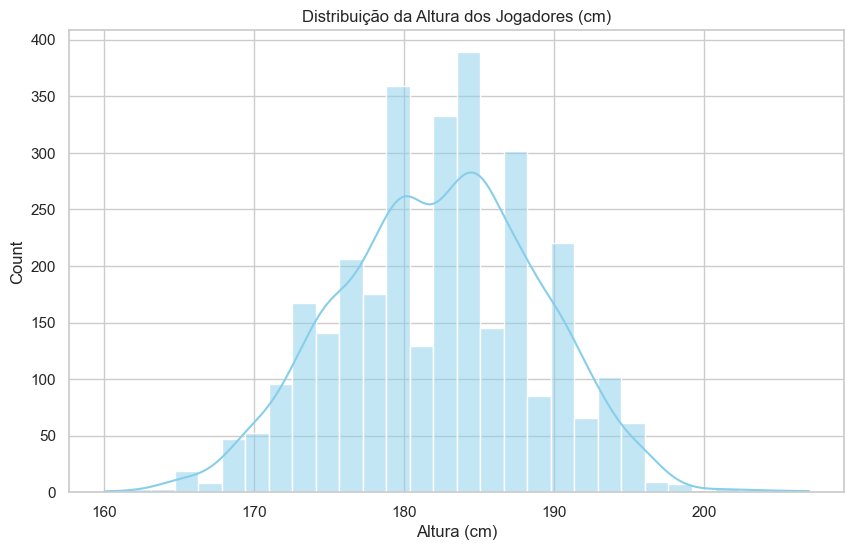

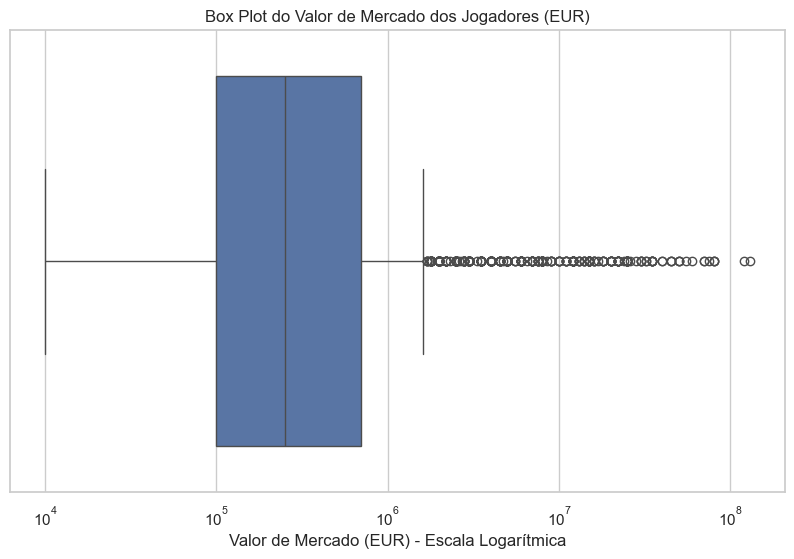

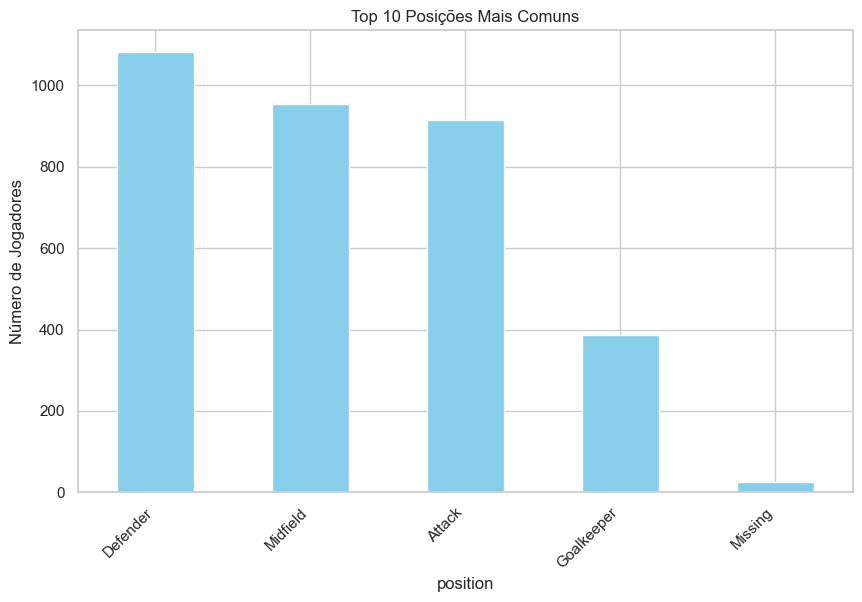

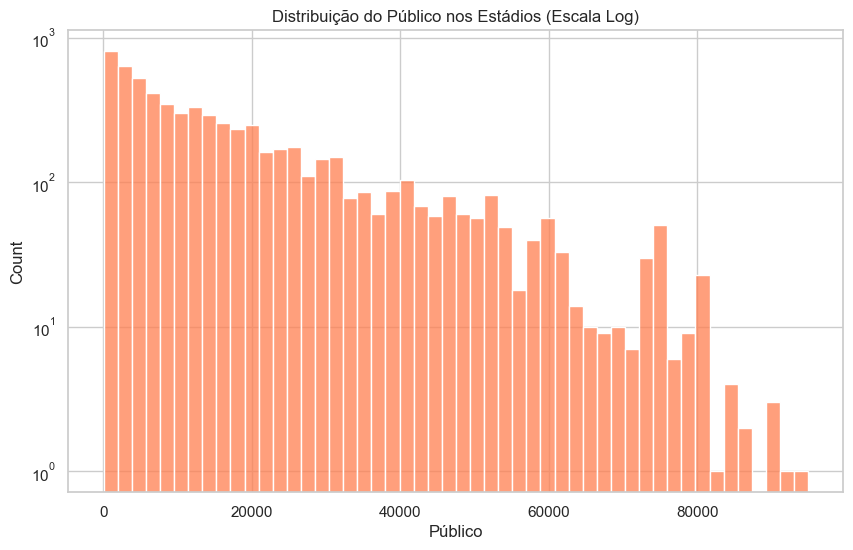

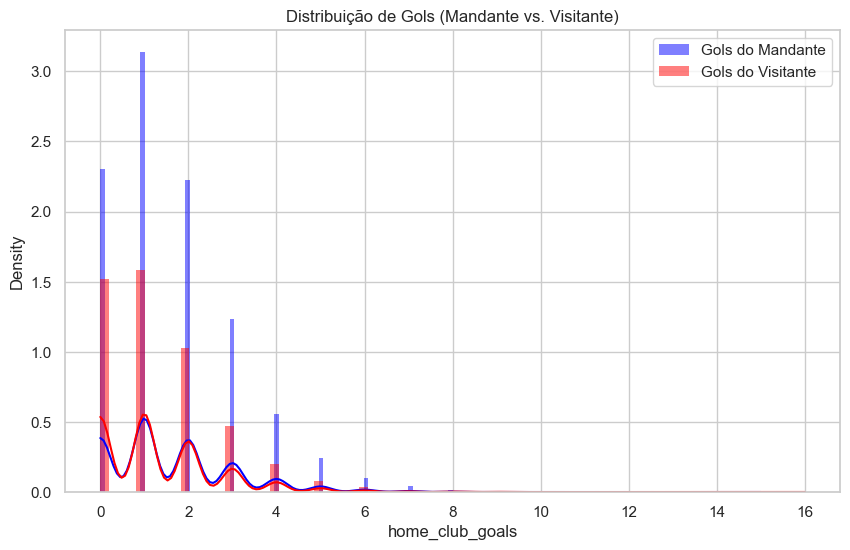

In [28]:

# 1. Histograma da Altura
plotar_histograma(
    series=players_pd_sample['height_in_cm'],
    titulo='Distribuição da Altura dos Jogadores (cm)',
    xlabel='Altura (cm)'
)

# 2. Box Plot do Valor de Mercado
plotar_boxplot(
    series=players_pd_sample['market_value_in_eur'],
    titulo='Box Plot do Valor de Mercado dos Jogadores (EUR)',
    xlabel='Valor de Mercado (EUR) - Escala Logarítmica',
    xscale='log'
)

# 3. Gráfico de Barras para Posição
plotar_barras_contagem(
    series=players_pd_sample['position'],
    titulo='Top 10 Posições Mais Comuns',
    ylabel='Número de Jogadores'
)

# 4. Histograma de Público
plotar_histograma(
    series=games_pd_sample['attendance'],
    titulo='Distribuição do Público nos Estádios (Escala Log)',
    xlabel='Público',
    bins=50,
    cor='coral',
    yscale='log',
    kde=False # KDE não faz muito sentido em escala log e com essa distribuição
)

# 5. Comparação de Gols (Casa vs. Visitante)
plotar_histogramas_comparativos(
    series1=games_pd_sample['home_club_goals'],
    label1='Gols do Mandante',
    cor1='blue',
    series2=games_pd_sample['away_club_goals'],
    label2='Gols do Visitante',
    cor2='red',
    titulo='Distribuição de Gols (Mandante vs. Visitante)'
)

--- Matriz de Correlação para: Jogadores ---


25/07/02 11:04:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


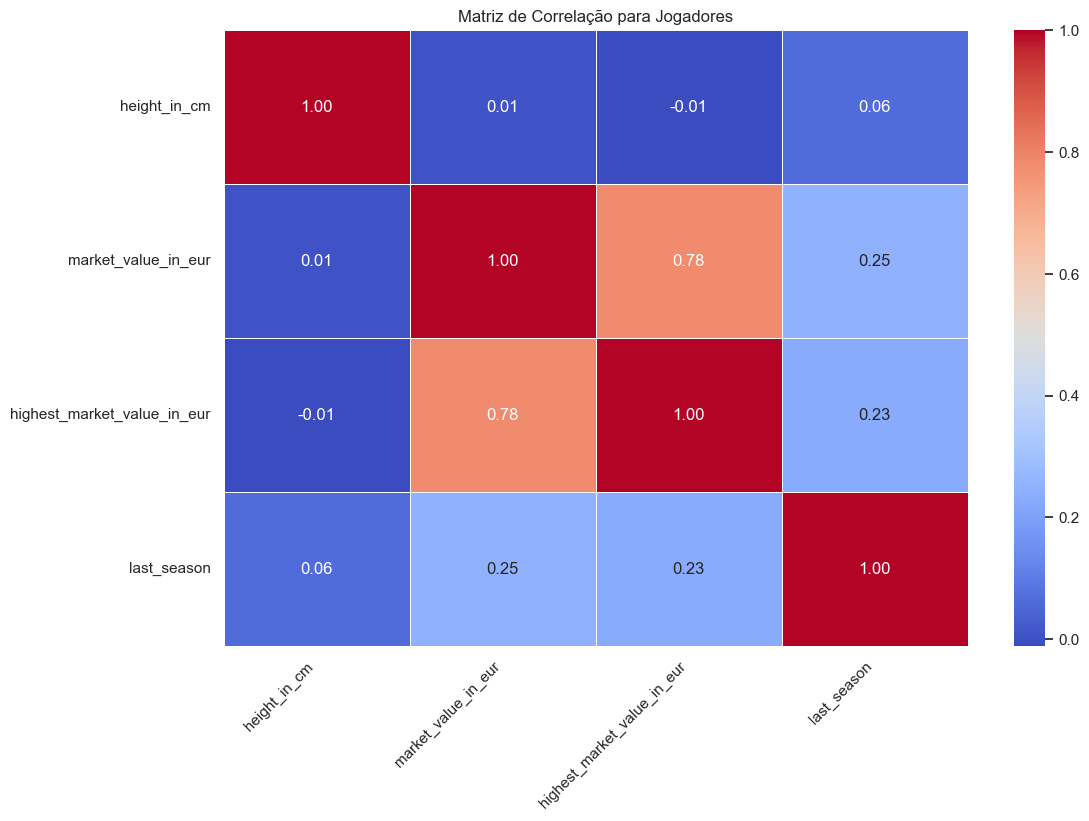



--- Matriz de Correlação para: Clubes ---


Não há dados suficientes para calcular a correlação após remover nulos.


In [29]:
# Análise para 'players_bronze'
colunas_players = ["height_in_cm", "market_value_in_eur", "highest_market_value_in_eur", "last_season"]
plotar_matriz_correlacao(players_bronze, colunas_players, "Jogadores")

# Análise para 'clubs_bronze'
# Primeiro, precisamos converter os valores em euros, como fizemos na camada Silver
clubs_bronze_for_corr = (clubs_bronze
                         .withColumn("total_market_value_eur", parse_euro("total_market_value"))
                         .withColumn("net_transfer_record_eur", parse_euro("net_transfer_record")))

colunas_clubs = ["squad_size", "average_age", "foreigners_number", "national_team_players", "stadium_seats", "total_market_value_eur", "net_transfer_record_eur"]
plotar_matriz_correlacao(clubs_bronze_for_corr, colunas_clubs, "Clubes")

--- Distribuição Categórica para: Jogadores [foot] ---


/var/folders/43/pnk67xfx0nn_r097mntmksy80000gn/T/ipykernel_45399/2885952996.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')


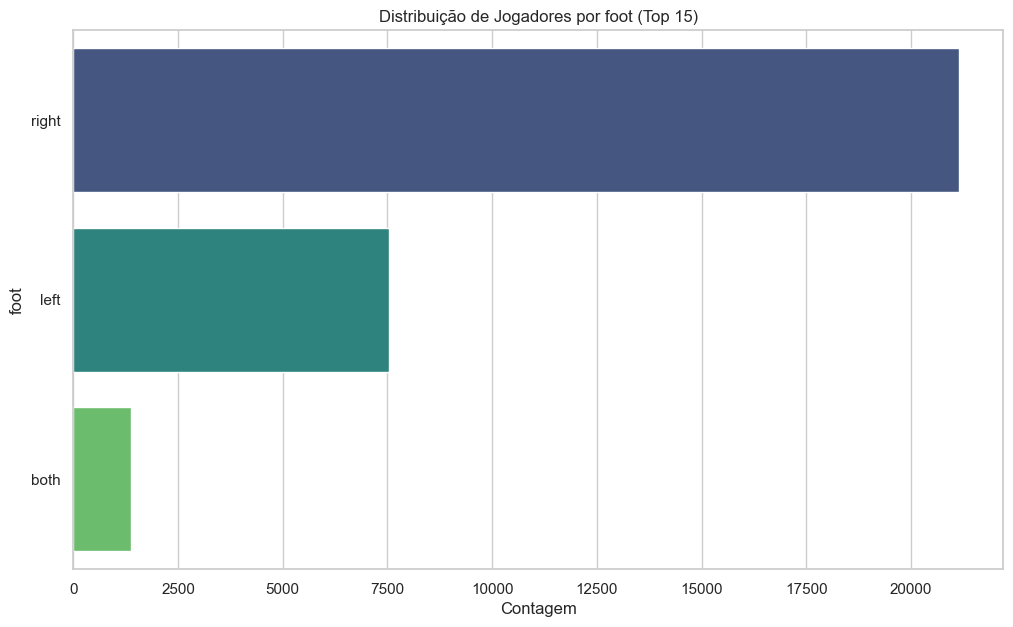



--- Distribuição Categórica para: Jogadores [sub_position] ---


/var/folders/43/pnk67xfx0nn_r097mntmksy80000gn/T/ipykernel_45399/2885952996.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')


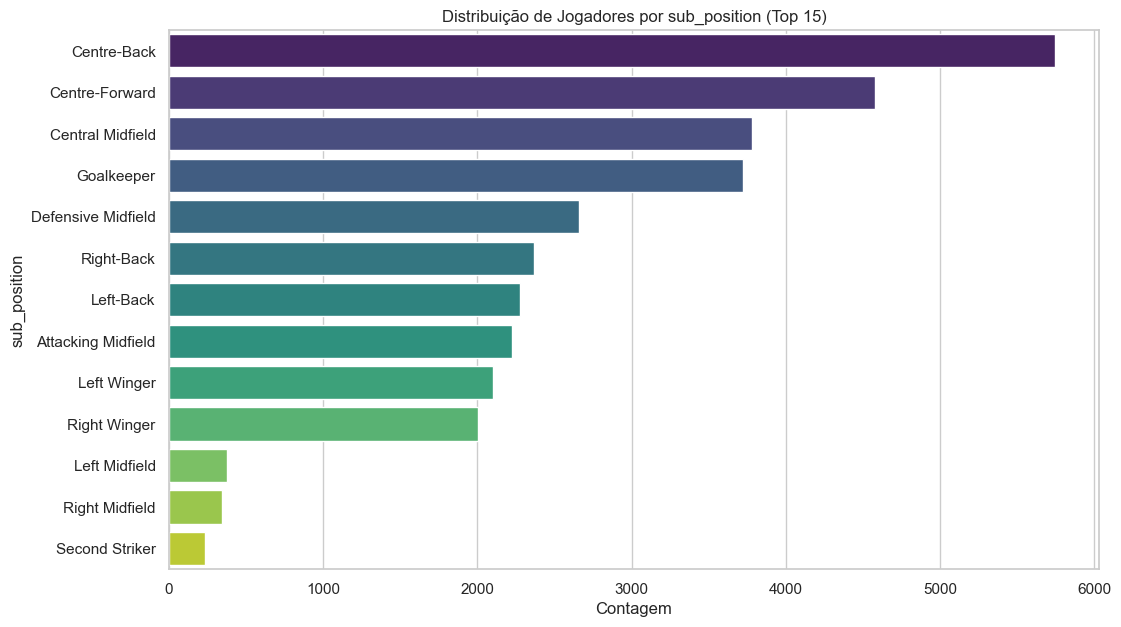



--- Distribuição Categórica para: Competições [confederation] ---


/var/folders/43/pnk67xfx0nn_r097mntmksy80000gn/T/ipykernel_45399/2885952996.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=counts_pd, x='count', y=coluna, palette='viridis')


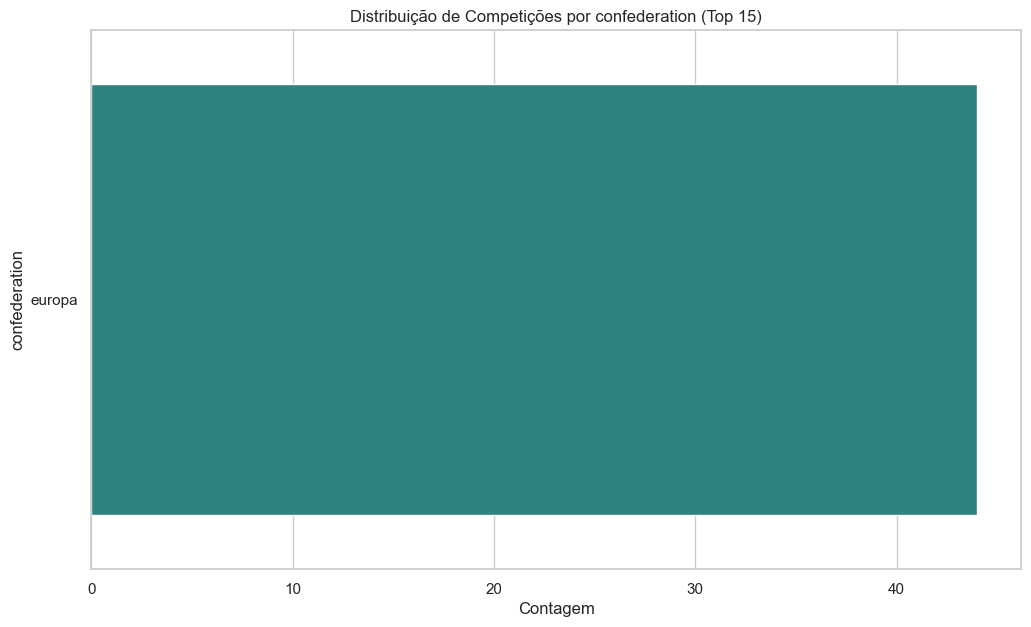

In [30]:
# Análise do pé dominante dos jogadores
plotar_distribuicao_categorica(players_bronze, "foot", "Jogadores")

# Análise da sub-posição dos jogadores
plotar_distribuicao_categorica(players_bronze, "sub_position", "Jogadores")

# Análise da confederação das competições
plotar_distribuicao_categorica(competitions_bronze, "confederation", "Competições")

In [33]:

# Identificar outliers no valor de mercado dos jogadores
identificar_outliers(players_bronze.filter("market_value_in_eur > 0"), "market_value_in_eur")

# Identificar outliers no público dos jogos
identificar_outliers(games_bronze.filter("attendance > 0"), "attendance")

--- Análise de Outliers para: market_value_in_eur ---
Q1: 100000.0, Q3: 650000.0, IQR: 550000.0
Limite Inferior: -725000.0, Limite Superior: 1475000.0
⚠️ Encontrados 5015 outliers na coluna 'market_value_in_eur'. Amostra:
+-------------------+
|market_value_in_eur|
+-------------------+
|2.0E8              |
|2.0E8              |
|1.8E8              |
|1.8E8              |
|1.7E8              |
|1.5E8              |
|1.4E8              |
|1.4E8              |
|1.3E8              |
|1.3E8              |
+-------------------+
only showing top 10 rows


--- Análise de Outliers para: attendance ---
Q1: 4340.0, Q3: 26004.0, IQR: 21664.0
Limite Inferior: -28156.0, Limite Superior: 58500.0
⚠️ Encontrados 2776 outliers na coluna 'attendance'. Amostra:
+----------+
|attendance|
+----------+
|99354     |
|99354     |
|98902     |
|98761     |
|98760     |
|98485     |
|98299     |
|97939     |
|97183     |
|96973     |
+----------+
only showing top 10 rows




--- Gerando Série Temporal: Evolução do Número de Transferências por Temporada ---


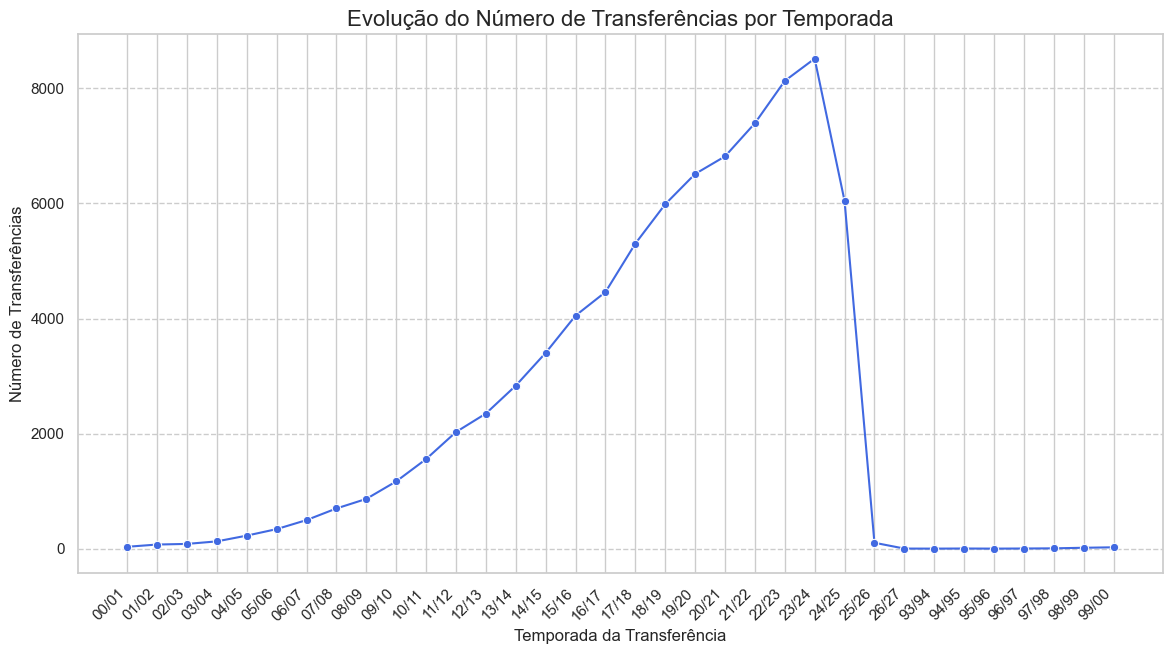



--- Gerando Série Temporal: Evolução do Valor de Mercado Médio dos Jogadores (EUR) ---


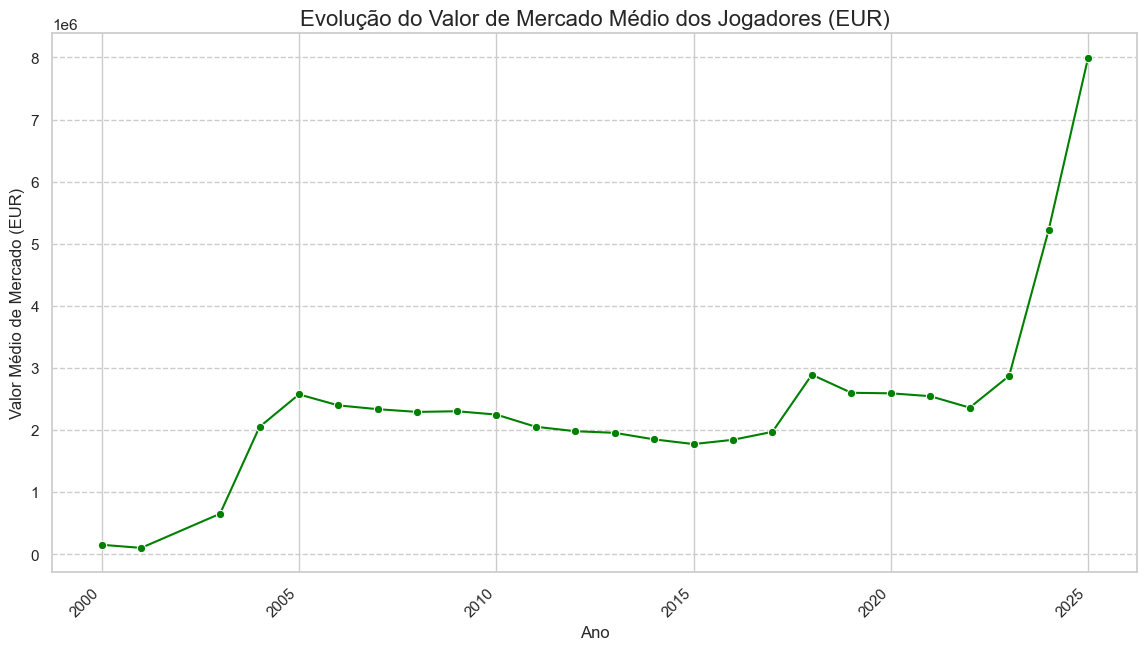

In [34]:
# 1. Evolução do número de transferências por temporada
plotar_serie_temporal(
    df=transfers_bronze,
    coluna_tempo='transfer_season',
    titulo='Evolução do Número de Transferências por Temporada',
    xlabel='Temporada da Transferência',
    ylabel='Número de Transferências',
    agregacao='count' # 'count' é o padrão, mas explicitamos para clareza
)

# 2. Evolução do valor de mercado médio ao longo do tempo
plotar_serie_temporal(
    df=valuations_bronze.filter("market_value_in_eur > 0"),
    coluna_tempo='date',
    titulo='Evolução do Valor de Mercado Médio dos Jogadores (EUR)',
    xlabel='Ano',
    ylabel='Valor Médio de Mercado (EUR)',
    agregacao='avg',
    coluna_valor='market_value_in_eur',
    unidade_tempo='year',
    cor='green'
)

--- 
### Camada Silver: Limpeza, Padronização e Persistência

A camada **Silver** é onde os dados da camada Bronze são transformados em tabelas limpas, consistentes e prontas para análise. As seguintes operações são realizadas:

* **`base_clean`:** Uma função de limpeza básica que remove duplicatas com base em uma chave primária e adiciona um timestamp de ingestão para rastreabilidade.
* **`parse_euro` (UDF):** Uma função criada para tratar um caso específico de parsing. As colunas de valor de mercado no dataset de clubes vêm em um formato de texto não padronizado (ex: `"+€3.05m"`). Esta UDF utiliza uma expressão regular (regex) para extrair o valor numérico e convertê-lo para um tipo `double` em euros.
* **Persistência em Delta:** Após a limpeza, cada DataFrame é salvo no formato **Delta Lake**. Ele materializa os dados limpos no disco, o que melhora a performance das etapas seguintes (que agora lerão de arquivos Parquet otimizados) e garante a recuperabilidade do pipeline em caso de falhas.

In [ ]:
clubs_silver = (base_clean(clubs_bronze, ["club_id"])
                .withColumn("total_market_value_eur", parse_euro("total_market_value"))
                .withColumn("net_transfer_record_eur", parse_euro("net_transfer_record"))
                .drop("total_market_value","net_transfer_record"))

games_silver = base_clean(games_bronze, ["game_id"])
players_silver = base_clean(players_bronze, ["player_id"])
valuations_silver = base_clean(valuations_bronze, ["player_id","date"])
transfers_silver = base_clean(transfers_bronze, ["player_id","transfer_date"])
club_games_silver = base_clean(club_games_bronze, ["game_id","club_id"])
competitions_silver = base_clean(competitions_bronze, ["competition_id"])
events_silver = base_clean(events_bronze, ["game_event_id"])
lineups_silver = base_clean(lineups_bronze, ["game_lineups_id"])

# Persistir como Delta para reuso
(spark
 .createDataFrame([], T.StructType([])))  # placeholder para evitar saída longa

for name, df in [("apps",apps_silver),("clubs",clubs_silver),("games",games_silver),
                 ("players",players_silver),("valuations",valuations_silver),
                 ("transfers",transfers_silver),("club_games",club_games_silver),
                 ("competitions",competitions_silver),("events",events_silver),
                 ("lineups",lineups_silver)]:
    df.write.mode("overwrite").format("delta").save(f"{PATH}/{name}")

25/07/02 09:40:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/07/02 09:40:19 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/02 09:40:33 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/02 09:40:37 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/02 09:40:40 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/02 09:40:46 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
25/07/02 09:40:55 WARN MemoryManager

### Modelagem para os Eixos de Análise

Com os dados limpos e persistidos na camada Silver, iniciamos a fase de **Engenharia de Atributos** e modelagem. Aqui, aplicamos a lógica de negócio para criar os DataFrames que responderão diretamente às perguntas definidas nos três eixos do projeto.

* **Eixo 1 (Valor de Mercado e ROI):**
    * No DataFrame `valuations_enriched`, utilizamos **funções de janela** (`Window`) para calcular a idade do jogador em cada data de avaliação e a variação percentual de valor (`pct_growth`) em relação à medição anterior.
    * No DataFrame `roi`, unimos dados de transferências e de valorações para calcular um ROI (Retorno sobre Investimento) simplificado, medindo a valorização do atleta nos 12 meses seguintes à sua contratação.

* **Eixo 2 (Impacto Tático):**
    * O DataFrame `apps_enriched` é enriquecido com informações de contexto do jogo (se o jogador estava em casa ou fora, se foi titular ou substituto).
    * `tactical_impact` agrega essas informações por jogador para criar métricas de desempenho médio, como média de gols, assistências e taxa de participação como substituto.

* **Eixo 3 (Carreira e Conexões):**
    * O DataFrame `career_edges` é preparado especificamente para o Neo4j. Ele isola as informações de transferência, formatando os dados para representar as **arestas** (relações `TRANSFERRED_TO`) do nosso futuro grafo de carreiras.

---
Estruturação Eixo 1

In [24]:
w_date = Window.partitionBy("player_id").orderBy("date")

valuations_enriched = (valuations_silver
                       .join(players_silver.select("player_id","date_of_birth"), "player_id")
                       .withColumn("age",
                                   F.floor(F.months_between("date","date_of_birth")/12))
                       .withColumn("prev_value",
                                   F.lag("market_value_in_eur").over(w_date))
                       .withColumn("pct_growth",
                                   (F.col("market_value_in_eur")-F.try_divide(F.col("prev_value"), F.col("prev_value")))))

# ROI de transferências (simples: variação de valor em 12 meses após compra)
buy_side = (transfers_silver
            .select("player_id","transfer_date","to_club_id","transfer_fee")
            .withColumnRenamed("transfer_date","buy_date"))

roi = (buy_side
       .join(valuations_enriched, (valuations_enriched.player_id == buy_side.player_id) &
                                  (valuations_enriched.date >= buy_side.buy_date) &
                                  (valuations_enriched.date <= F.add_months(buy_side.buy_date,12)))
       .groupBy(buy_side.player_id, "to_club_id","transfer_fee")
       .agg(F.max("market_value_in_eur").alias("value_after_12m"))
       .withColumn("roi_pct",
                   (F.col("value_after_12m")-F.try_divide(F.col("transfer_fee"), F.col("transfer_fee")))))

---
Estruturação Eixo 2

In [11]:
apps_enriched = (apps_silver
                 .join(games_silver.select("game_id","home_club_id","away_club_id",
                                           "home_club_goals","away_club_goals"),"game_id")
                 .withColumn("is_home",
                             F.when(F.col("player_club_id")==F.col("home_club_id"),1).otherwise(0))
                 .withColumn("is_sub",
                             F.when((F.col("minutes_played")<90) & (F.col("minutes_played")>0),1).otherwise(0))
                )

tactical_impact = (apps_enriched
                   .groupBy("player_id")
                   .agg(F.avg("goals").alias("avg_goals"),
                        F.avg("assists").alias("avg_assists"),
                        F.avg("is_sub").alias("sub_rate")))

---
Estruturação Eixo 3

In [15]:
career_edges = (transfers_silver
                .select("player_id","from_club_id","to_club_id","transfer_date")
                .withColumnRenamed("transfer_date","date"))

---
### Carga no MongoDB

Nesta etapa, preparamos e salvamos os dados no **MongoDB**. A escolha deste banco de dados se justifica pela sua natureza orientada a documentos, que é ideal para o nosso caso de uso.

O DataFrame `players_doc` é construído como um **documento denormalizado**. Ele agrega, para cada jogador, um conjunto rico de informações:
* Dados pessoais (do `players_silver`).
* Métricas de desempenho tático agregadas (do `tactical_impact`).
* Um **array aninhado** com o histórico completo de suas valorações de mercado.

Essa estrutura de "Perfil 360°" é extremamente eficiente, pois permite recuperar todas as informações de um jogador com uma única consulta, eliminando a necessidade de `JOINs` complexos no momento da leitura, o que é uma grande vantagem do modelo de documentos.

In [20]:
# DataFrame que será usado no join
clubs_join_df = clubs_silver.select(
    F.col("club_id").alias("current_club_id"),
    F.col("name").alias("current_club_name")
)

# Construção do DataFrame 'players_doc' com a correção
players_doc = (players_silver
               .join(tactical_impact, "player_id", "left")
               .join(valuations_enriched.groupBy("player_id")
                     .agg(F.collect_list(F.struct("date", "market_value_in_eur")).alias("valuations")),
                     "player_id", "left")
               # O join que causa a duplicidade
               .join(clubs_join_df, "current_club_id", "left")
               # ✅ A SOLUÇÃO: Remove a coluna duplicada que veio do join com clubs_join_df
               .drop(clubs_join_df.current_club_name)
               .drop("_ingest_timestamp")
)

# Verificação do schema 
print("Schema do DataFrame 'players_doc:")
players_doc.printSchema()

(players_doc
 .write
 .format("mongodb")
 .option("collection","players")
 .mode("overwrite")
 .save())

Schema do DataFrame 'players_doc:
root
 |-- current_club_id: long (nullable = true)
 |-- player_id: long (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- last_season: integer (nullable = true)
 |-- player_code: string (nullable = true)
 |-- country_of_birth: string (nullable = true)
 |-- city_of_birth: string (nullable = true)
 |-- country_of_citizenship: string (nullable = true)
 |-- date_of_birth: timestamp (nullable = true)
 |-- sub_position: string (nullable = true)
 |-- position: string (nullable = true)
 |-- foot: string (nullable = true)
 |-- height_in_cm: integer (nullable = true)
 |-- contract_expiration_date: string (nullable = true)
 |-- agent_name: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- url: string (nullable = true)
 |-- current_club_domestic_competition_id: string (nullable = true)
 |-- current_club_name: string (nullable = true)
 |-- market_value_in

---
### Carga no Neo4j

Aqui, populamos nosso banco de dados de grafos **Neo4j**. Este modelo é naturalmente adequado para representar e analisar as conexões e trajetórias na carreira dos atletas. O processo é dividido em duas partes:

1.  **Criação dos Nós:**
    * Os `:Player` (nós de jogador) são criados a partir do `players_silver`.
    * Os `:Club` (nós de clube) são criados a partir do `clubs_silver`.
    * Utilizamos a opção `.option("node.keys", "id")` para garantir a **idempotência**, ou seja, que um mesmo jogador ou clube não seja criado mais de uma vez, mesmo que o código seja executado múltiplas vezes.

2.  **Criação das Arestas:**
    * As relações `:TRANSFERRED_TO` são criadas a partir do DataFrame `career_edges`.
    * O conector do Spark mapeia as colunas de origem (`source_id`) e de destino (`target_id`) para conectar os nós `:Player` e `:Club` correspondentes, criando o grafo que representa as transferências.

In [18]:
# Nós: Player
(players_silver
 .selectExpr("player_id as id","name","date_of_birth")
 .write
 .format("org.neo4j.spark.DataSource")
 .option("url", NEO4J_URL)
 .option("authentication.type","basic")
 .option("authentication.basic.username", NEO4J_AUTH[0])
 .option("authentication.basic.password", NEO4J_AUTH[1])
 .option("labels",":Player")
 .option("node.keys", "id")  # Adiciona a chave para identificar o nó
 .mode("overwrite")
 .save())

# Nós: Club
(clubs_silver
 .selectExpr("club_id as id","name")
 .write
 .format("org.neo4j.spark.DataSource")
 .option("url", NEO4J_URL)
 .option("authentication.type","basic")
 .option("authentication.basic.username", NEO4J_AUTH[0])
 .option("authentication.basic.password", NEO4J_AUTH[1])
 .option("labels",":Club")
 .option("node.keys", "id")  # Adiciona a chave para identificar o nó
 .mode("overwrite")
 .save())

# Arestas: TRANSFERRED_TO
(career_edges
 .selectExpr("player_id as source_id",
             "to_club_id as target_id",
             "date")
 .coalesce(1)                                     # evita deadlocks
 .write
 .format("org.neo4j.spark.DataSource")
 .option("url", NEO4J_URL)
 .option("authentication.type","basic")
 .option("authentication.basic.username", NEO4J_AUTH[0])
 .option("authentication.basic.password", NEO4J_AUTH[1])
 .option("relationship","TRANSFERRED_TO")
 .option("relationship.save.strategy","keys")
 .option("relationship.source.labels",":Player")
 .option("relationship.target.labels",":Club")
 .option("relationship.source.node.keys","source_id")
 .option("relationship.target.node.keys","target_id")
 .mode("append")
 .save())


---
### Verificação Final e Métricas de Qualidade

Como etapa final do nosso pipeline ETL, executamos duas ações importantes:

1.  **Cálculo de Métricas de Qualidade:** Para os nossos principais DataFrames enriquecidos, calculamos e persistimos uma tabela de métricas. Isso inclui a contagem total de linhas e um dicionário com a contagem de valores nulos para cada coluna. Esta é uma prática profissional essencial para monitorar a saúde e a integridade dos dados ao longo do tempo.

2.  **Visualização e Validação:** Lemos de volta todas as tabelas Delta que foram salvas na camada Silver e as exibimos com `.show()`. Este passo serve como uma verificação visual final para garantir que o pipeline foi executado como esperado e que os dados estão estruturados corretamente antes de passarmos para a fase de análise e consulta nos bancos de dados NoSQL.

In [28]:
quality_metrics = []

for name, df in [("players_doc", players_doc),
                 ("games_silver", games_silver),
                 ("valuations_enriched", valuations_enriched)]:
    
    print(f"Calculando métricas para a tabela: {name}...")
    
    quality_metrics.append(Row(
        table=name,
        rows=df.count(),
        nulls=df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns])
              .select([F.sum(c).alias(c) for c in df.columns]).first().asDict(),
        # ✅ PASSO 2: Use a função do Python para pegar o timestamp atual
        timestamp=datetime.now()
    ))

print("\Métricas calculadas. Criando o DataFrame final...")

# Esta parte agora vai funcionar, pois quality_metrics só contém dados Python
(spark.createDataFrame(quality_metrics)
      .write.mode("append").format("delta")
      .save(f"{PATH}/quality_metrics")) # Ajustei o caminho para o seu padrão

print("\n✅ Métricas de qualidade salvas com sucesso!")

Calculando métricas para a tabela: players_doc...


Calculando métricas para a tabela: games_silver...


Calculando métricas para a tabela: valuations_enriched...


\Métricas calculadas. Criando o DataFrame final...



✅ Métricas de qualidade salvas com sucesso!


In [32]:
# Carregando a tabela de métricas de qualidade de volta para um DataFrame
quality_df = spark.read.format("delta").load(f"{PATH}/quality_metrics")
print("Visualizando a tabela de Métricas de Qualidade:")
quality_df.show(truncate=False)

# Carregando a tabela de jogadores
players_final_df = spark.read.format("delta").load(f"{PATH}/players")
print("\nVisualizando a tabela final de Jogadores:")
players_final_df.show(5)

# Carregando a tabela de apariceos
apps_final_df = spark.read.format("delta").load(f"{PATH}/apps")
print("\nVisualizando a tabela final de Aparições:")
apps_final_df.show(5)

# Carregando a tabela de clubes
clubs_final_df = spark.read.format("delta").load(f"{PATH}/clubs")
print("\nVisualizando a tabela final de Clubes:")
clubs_final_df.show(5)

# Carregando a tabela de jogos do clube
club_games_final_df = spark.read.format("delta").load(f"{PATH}/club_games")
print("\nVisualizando a tabela final de Jogos dos clubes:")
club_games_final_df.show(5)

# Carregando a tabela de competicoes
competitions_final_df = spark.read.format("delta").load(f"{PATH}/competitions")
print("\nVisualizando a tabela final de Competições:")
competitions_final_df.show(5)

# Carregando a tabela de eventos
events_final_df = spark.read.format("delta").load(f"{PATH}/events")
print("\nVisualizando a tabela final de Eventos:")
events_final_df.show(5)

# Carregando a tabela de escalações
lineups_final_df = spark.read.format("delta").load(f"{PATH}/lineups")
print("\nVisualizando a tabela final de Escalações:")
lineups_final_df.show(5)

# Carregando a tabela de transferencias
transfers_final_df = spark.read.format("delta").load(f"{PATH}/transfers")
print("\nVisualizando a tabela final de Transferências:")
transfers_final_df.show(5)

# Carregando a tabela de valuations
valuations_final_df = spark.read.format("delta").load(f"{PATH}/valuations")
print("\nVisualizando a tabela final de Valuations:")
valuations_final_df.show(5)

Visualizando a tabela de Métricas de Qualidade:
+-------------------+------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------+
|table              |rows  |nulls                                                                                                                                                                                                                                                                                   

+-------------+-------+---------+--------------+----------------------+----------+--------------------+--------------+------------+---------+-----+-------+--------------+--------------------+
|appearance_id|game_id|player_id|player_club_id|player_current_club_id|      date|         player_name|competition_id|yellow_cards|red_cards|goals|assists|minutes_played|   _ingest_timestamp|
+-------------+-------+---------+--------------+----------------------+----------+--------------------+--------------+------------+---------+-----+-------+--------------+--------------------+
| 2218677_2865|2218677|     2865|           506|                   167|2012-08-11|Stephan Lichtsteiner|           SCI|           1|        0|    0|      0|            89|2025-07-02 02:12:...|
|2218677_37666|2218677|    37666|           506|                    46|2012-08-11|        Arturo Vidal|           SCI|           0|        0|    1|      1|           120|2025-07-02 02:12:...|
| 2218677_5880|2218677|     5880|       